Populating the interactive namespace from numpy and matplotlib


/home/michael/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


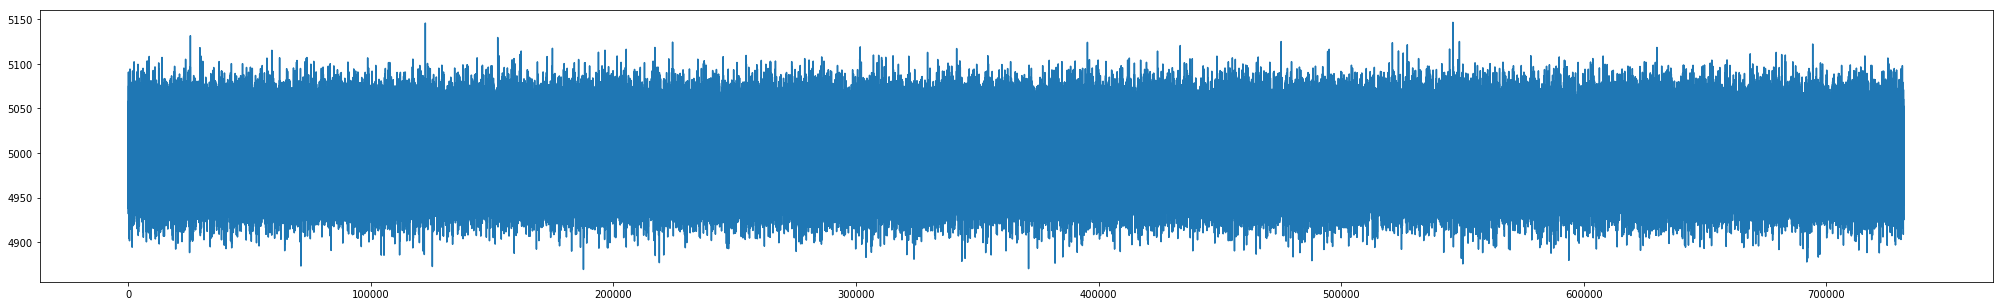

In [3]:
%matplotlib inline
%pylab inline
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import numpy as np
from IPython.display import Audio, Image
import librosa, librosa.display
import time
import random
import seaborn
from scipy import signal
from __future__ import division #so 1/2 = 0.5, not 1/2=0


'''create your white noise once'''

# duration for white noise -> still up to debate what would be most efficient and appropriate for experimental setup
dur_noise=30

# set sampling rate
num_samples = 24400

#freq in hz -> placeholder: not sure what would be apropriate here
freq=np.arange(10,10000,dur_noise*num_samples)


# present on background noise with equivalent rectangular bandwith 
# → minimize variation inf hearing tresholds between frequencies and participants 
# adapted from: http://www.ee.ic.ac.uk/hp/staff/dmb/voicebox/doc/voicebox/frq2erb.html
u=[6.23**-6, 93.39**-3, 28.52]
p=[-14678.5, -311.9]
a=11.17
c=-14678.5
k=676170.42
h=47.065

# define bandwith for every frequency in freq-var (here 10 - 10000)
erb=[]
bnd=[]
for element in freq:
    g=np.absolute(element)
    erb1=11.17268*np.sign(element)*scipy.log(1+46.06538*g/(g+14678.49))
    erb.append(erb1)
    bnd1=np.polyval(u,g)
    bnd.append(bnd1)

# randomly pick out of calculated freq-range to set gaussian white noise?
# placeholder: not sure what to pick as mean here
samples = (np.random.normal(5000,bnd, dur_noise*num_samples))

display(Audio(samples,rate=sr))
plt.figure(figsize=(35,5))
plt.plot(samples)


In [ ]:
#X = scipy.fft(samples)
#X_mag = numpy.absolute(X)
#f = numpy.linspace(0, sr, len(X_mag)) # frequency variable
#plt.figure(figsize=(13, 5))
#plt.plot(f, X_mag) # magnitude spectrum
#plt.xlabel('Frequency (Hz)')


In [4]:
'''create pure tones'''
# set sampling rate
sr = 24400#samplerate
#duration of pure tone
dur = 0.19 #note duration in seconds
# construct array for pure tone presentation
t = scipy.linspace(0, dur, dur*sr, endpoint=False)
# dur of ramps = twice of what is actually needed, will be sliced later
dur_ramp= 0.04
t_ramp = scipy.linspace(0.0,dur_ramp,dur_ramp*sr)
# set amplitude
amp= 0.24
# set pahse shift
phi=scipy.pi//2
# define timeline for plotting
timeline=np.arange(t.size)/sr

# simple sine evelope -> helps with reshaping of ramps
def sine_envelope(t):
    return np.square(scipy.sin((1.0)*np.pi*t/t[-1])) #t[-1] = last value

# define list of nominal frequencies in hz
nominal_frequencies=[200.0, 338.8, 573.8, 971.9, 1646.2, 2788.4, 4723.1, 8000.0]


# create lists to append to
range_frequencies=[]
rand_freq=[]
for i in nominal_frequencies:
    for f in range(4):
        #varying nominal frequencies in range of 1 semitone
        #x¹²=2
        #x=2**(1/12)=1.0594630943593
        freq_range=int(i//1.06),int(i*1.06)
        range_frequencies.append(freq_range)


counter1=0
for i in range_frequencies:
    # randomly pick a freq in the specified range
    rand_pick=random.randint((*range_frequencies[counter1]))
    rand_freq.append(rand_pick)
    counter1+=1
    ### counter is used to print which nominal freq was picked
    print('freq_range='+str(i)+'; picked freq='+str(rand_pick))

def create_sounds():
    '''function fitting onset and offset ramps to sounds, plot and output sounds and append sounds to list'''
    ### create list to append to
    list_sounds=[]

    for f in rand_freq:
        ### create your pure tone for each freq in our list
        pure_tone =(amp*scipy.sin(2.0*np.pi*f*t+phi))

        ## define your onset ramp
        onset_r=(amp*scipy.cos(2*scipy.pi*f*(t_ramp)))
        ### multiply it by your sine env
        onset = sine_envelope(t_ramp)*onset_r

        ## uncomment to plot your tones for visual inspection
        timeline=np.arange(pure_tone.size)/sr
        #plt.figure(figsize=(100,5))
        #plt.plot(timeline,pure_tone)
        #plt.xlabel('Amplitude')
        #plt.ylabel('time')
        #plt.title('Frequency='+str(f))

        ###np.split -> split array into two parts
        ### split your ramp into onset - offset ramp 
        split_ramp=np.split(onset,2)
        onset_split = split_ramp[0]
        offset_split = split_ramp[1]


        ### define timeline for plotting
        timeline=np.arange(offset_split.size)/sr

        ### plot your tones for visual inspection
        #plt.figure(figsize=(100,4))
        #plt.plot(timeline,offset_split)
        #plt.xlabel('Amplitude')
        #plt.ylabel('time')
        #plt.title('Frequency='+str(f))


        ### define timeline for plotting
        timeline=np.arange(onset_split.size)/sr
        #plt.figure(figsize=(100,4))
        #plt.plot(timeline,onset_split)
        #plt.xlabel('Amplitude')
        #plt.ylabel('time')
        #plt.title('Frequency='+str(f))
        
        ### create counter to have a second condition on when to advance in the loop
        counter=0
        ### create list to append to
        onset_pure_offset= []
        for i in range(len(pure_tone[0:500])):
            ### find closest aproximation of overlapping points between maximum of onset ramp and pure tone 
            ### to minimise clicking sounds at transition
            if np.round(pure_tone[i],decimals=2) == np.round(np.amax(onset_split),decimals=2) and counter==0:
                ### append onset ramp from start to its maximun to list
                onset_pure_offset.append(onset_split[0:(np.argmax(onset_split))])
                #print('len onset'+str(len(onset_split[0:(np.argmax(onset_split))])))
                ### append onset matched pure tone
                onset_pure_offset.append(pure_tone[i:])
                ### cocncatenate list
                sound= concatenate(onset_pure_offset)
                counter+=1
                for i in range(len(sound)-1,0,-1):
                    ### repeat step for offset ramp
                    if np.round(sound[i],decimals=2) == np.round(np.amax(offset_split),decimals=2)and counter==1:
                        sound=sound[0:i]
                        #print('len tone'+str(len(sound)))
                        sound=np.append([sound],[offset_split[np.argmax(offset_split):]])
                        
                        ### plot your finished tone
                        ### define timeline for plotting
                        timeline=np.arange(sound.size)/sr
                        #plt.figure(figsize=(100,5))
                        #plt.xlabel('Amplitude')
                        #plt.ylabel('time')
                        #plt.title('Frequency='+str(f))
                        #plt.plot(timeline,sound)
                        #plt.title('Frequency='+str(f))
                        #display(Audio(sound, rate=sr))
                        print(str(f)+': length of sound= '+str(len(sound)))
                        list_sounds.append(sound)
                        counter+=1
                        break
    return list_sounds
# function call                       
list_sounds=create_sounds()

# create a failsafe for unexpected problems in the sound creation
# check if the list of sounds is complete
restart=True
while restart:
    if len(list_sounds)!=32:
        # if len of list sounds is not 32 rerun create sounds function
        print(len(list_sounds))
        list_sounds=create_sounds()
        print('WARNING! dropped one sound during creation -> rerunning loop!')
        restart=True
        print(len(list_sounds))
    elif len(list_sounds)==32:
        restart=False

# print a simple warning if the length of certain sounds does not match the criteria
counter_f=0
for i in list_sounds:
    counter_f+=1
    if len(i)<5450:
        print('WARNING! sound '+str(counter_f)+' is shorter than usual length')


/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


freq_range=(188, 212); picked freq=196
freq_range=(188, 212); picked freq=204
freq_range=(188, 212); picked freq=198
freq_range=(188, 212); picked freq=198
freq_range=(319, 359); picked freq=338
freq_range=(319, 359); picked freq=334
freq_range=(319, 359); picked freq=330
freq_range=(319, 359); picked freq=346
freq_range=(541, 608); picked freq=548
freq_range=(541, 608); picked freq=560
freq_range=(541, 608); picked freq=559
freq_range=(541, 608); picked freq=604
freq_range=(916, 1030); picked freq=1005
freq_range=(916, 1030); picked freq=931
freq_range=(916, 1030); picked freq=921
freq_range=(916, 1030); picked freq=938
freq_range=(1553, 1744); picked freq=1700
freq_range=(1553, 1744); picked freq=1638
freq_range=(1553, 1744); picked freq=1710
freq_range=(1553, 1744); picked freq=1663
freq_range=(2630, 2955); picked freq=2759
freq_range=(2630, 2955); picked freq=2839
freq_range=(2630, 2955); picked freq=2942
freq_range=(2630, 2955); picked freq=2749
freq_range=(4455, 5006); picked fre

In [5]:
''' create dictionary for easy acces of sounds'''

# create lists for each frequency
twohundred_hz=[]
threethreeeight_hz=[]
fiveseventhree_hz=[]
ninesevenone_hz=[]
onesixfoursix_hz=[]
twoseveneighteight_hz=[]
fourseventwothree_hz=[]
eightthousand_hz=[]

# append data from list_sounds
for i in range(32):
    if i <= 3:
        sound=list_sounds[i]
        twohundred_hz.append(sound)
    elif i <=7:
        sound=list_sounds[i]
        threethreeeight_hz.append(sound)
    elif i <=11:
        sound=list_sounds[i]
        fiveseventhree_hz.append(sound)
    elif i <=15:
        sound=list_sounds[i]
        ninesevenone_hz.append(sound)        
    elif i <=19:
        sound=list_sounds[i]
        onesixfoursix_hz.append(sound)
    elif i <=23:
        sound=list_sounds[i]
        twoseveneighteight_hz.append(sound)
    elif i <=27:
        sound=list_sounds[i]
        fourseventwothree_hz.append(sound)
    elif i <=32:
        sound=list_sounds[i]
        eightthousand_hz.append(sound)

# write dictionary combining keywords with sound data
grouped_sound={'twohundred_hz':twohundred_hz,'threethreeeight_hz':threethreeeight_hz,'fiveseventhree_hz':fiveseventhree_hz
               ,'ninesevenone_hz':ninesevenone_hz,'onesixfoursix_hz':onesixfoursix_hz
               ,'twoseveneighteight_hz':twoseveneighteight_hz,'eightthousand_hz':eightthousand_hz}






In [6]:
''' short demo of how exp could sound like'''
# set autoplay to True, for examination purposes
for x in range(1):
    display(Audio(samples,rate=sr, autoplay=False))
    for i in range(4):
        # set autoplays to true, to automatically play tones
        time.sleep(1)
        display(Audio(twohundred_hz[i],rate=sr,autoplay=False))
    for i in range(4):
    # set autoplays to true, to automatically play tones
        time.sleep(1)

        display(Audio(ninesevenone_hz[i],rate=sr,autoplay=False))
    for i in range(4):
    # set autoplays to true, to automatically play tones
        time.sleep(1)

        display(Audio(onesixfoursix_hz[i],rate=sr,autoplay=False))
    for i in range(4):
    # set autoplays to true, to automatically play tones
        time.sleep(1)

        display(Audio(fiveseventhree_hz[i],rate=sr,autoplay=False))
